# Project: Web Scraping



In [1]:
from __future__ import print_function, division

In [1]:
import pandas as pd
import numpy as np
import html5lib
import calendar
# import quandl
import pandas_datareader.data as web
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

from sklearn import tree

Yale School of Management's International Center for Finance Data

Stock Market Confidence Indices for Oct 1989 - Aug 2017 for Institutional and Individual

In [ ]:
def cleanupYaleData(yaleData, name):
  df1 = yaleData[1]
  df2 = yaleData[3]
  df1 = df1[1:]
  df2 = df2[1:]
  df1 = df1.rename(columns=df1.iloc[0])
  df2 = df2.rename(columns=df2.iloc[0])
  df1 = df1[1:]
  df2 = df2[1:]
  df1 = df1[['Date','Index Value']]
  df2 = df2[['Date','Index Value']]
  df1.rename(index=str, columns={'Index Value': name+'InstIndexValue'}, inplace=True)
  df2.rename(index=str, columns={'Index Value': name+'IndIndexValue'}, inplace=True)
    
  df1.head()

  return df1, df2

In [3]:
def data_10year(url, filename):


    import requests
    from selenium import webdriver
    from selenium.webdriver.common.keys import Keys
    import os
    chromedriver = "C:\Program Files\chromedriver_win32\chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)
    import time
    driver.get(url)

    MVAIC_10year_selector = '//span[@id="zoom-10yr"]'
    driver.find_element_by_xpath(MVAIC_10year_selector).click()

    download_selector = '//span[contains(text(), "Download")]'
    driver.find_element_by_xpath(download_selector).click()

    download_csv = '//a[@id="download-data-csv"]'
    driver.find_element_by_xpath(download_csv).click()

    time.sleep(10)

    os.rename("C:/Users/aj282/Downloads/{}.csv".format(filename), "C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/student_submissions/projects/luther_project/data/{}.csv".format(filename))



In [4]:
def getSPYdata():
    
    import datetime
    from dateutil.relativedelta import relativedelta
    import pandas_datareader.data as web
    
    from pandas_datareader import data as pdr
    import fix_yahoo_finance as yf
    
    yf.pdr_override()

    start = datetime.datetime(2007, 10, 1)

    end = datetime.datetime(2017, 8, 31)

    SPY = pdr.get_data_yahoo("SPY", start, end)
#     SPY = web.DataReader("SPY", 'yahoo', start, end)
    
    SPY = pd.DataFrame(SPY)
    SPY = SPY.reset_index()
    
    SPY['Datetime'] = pd.to_datetime(SPY['Date'], format="%Y-%m-%d")

    SPY['Dateminus6'] = SPY['Datetime'].apply(lambda x: x - relativedelta(months=6))
    SPY.rename(index=str, columns={'Datetime': 'S&P Datetime'}, inplace=True)
    SPY['Month'] = SPY['Dateminus6'].map(lambda x: x.month)
    SPY['Year'] = SPY['Dateminus6'].map(lambda x: x.year)
    SPY['Month'] = SPY['Month'].apply(lambda x: calendar.month_abbr[x])
    SPY['Year'] = SPY['Year'].apply(str)
    SPY['Date'] = SPY['Month'] + " " + SPY['Year']
    
    SPY.drop_duplicates('Date', keep="last", inplace=True)
    SPY['month6Return'] = (SPY['Close'] - SPY['Close'].shift(6))/SPY['Close'].shift(6)
    SPY = SPY[SPY['S&P Datetime']>"2008-03-31"]
    SPY = SPY[['Date', 'month6Return']]
    
    return SPY

In [5]:
def getgdp():
    import datetime

    start = datetime.datetime(2007, 6, 1)
    end = datetime.datetime(2017, 8, 30)
    gdp=web.DataReader("GDP", "fred", start, end)
    
    gdp.reset_index(inplace = True)
    gdp.DATE = gdp.DATE.map(pd.to_datetime)
    gdp['Month'] = gdp['DATE'].map(lambda x: x.month)
    gdp['Year'] = gdp['DATE'].map(lambda x: x.year)
    gdp['Month'] = gdp['Month'].apply(lambda x: calendar.month_abbr[x])
    gdp['Year'] = gdp['Year'].apply(str)
    gdp['Date'] = gdp['Month'] + " " + gdp['Year']
    
    gdp['GDPGrowth'] = (gdp['GDP'] - gdp['GDP'].shift(1))/gdp['GDP'].shift(1)
    gdp1 = gdp[['Date', 'GDPGrowth']]
    
    return gdp1

In [9]:
def getAlldata(FREDlist, USOYI, USVI, USBODCI, USCCI, gdp):
    import pandas as pd
    import numpy as np
    import html5lib
    import calendar
#     import quandl
    import pandas_datareader.data as web
    
    if USOYI:

        url = 'http://som.yale.edu/faculty-research/our-centers-initiatives/international-center-finance/data/stock-market-confidence-indices/united-states-one-year-index'
        USOYI_wsd = pd.read_html(url)

        USOYI_inst, USOYI_ind = cleanupYaleData(USOYI_wsd, 'USOYI')

        smci = USOYI_inst.merge(USOYI_ind, on='Date')
        #     smci = smci.merge(USOYI_ind, on='Date')

        #United States One Year Index

    if USVI:
        url = 'http://som.yale.edu/faculty-research/our-centers-initiatives/international-center-finance/data/stock-market-confidence-indices/united-states-valuation-index'
        USVI_wsd = pd.read_html(url)
        #United States Valuation Index

        USVI_inst, USVI_ind = cleanupYaleData(USVI_wsd, 'USVI')

        if USOYI:

            smci = smci.merge(USVI_inst, on='Date')
            smci = smci.merge(USVI_ind, on='Date')
        else:
            smci = USVI_inst.merge(USVI_ind, on='Date')

    if USBODCI:
        url = 'http://som.yale.edu/faculty-research/our-centers-initiatives/international-center-finance/data/stock-market-confidence-indices/united-states-buy-dips-confidence-index'
        USBODCI_wsd = pd.read_html(url)
        #United States Buy-On-Dips Confidence Index

        USBODCI_inst, USBODCI_ind = cleanupYaleData(USBODCI_wsd, 'USBODCI')

        if USOYI or USVI:

            smci = smci.merge(USBODCI_inst, on='Date')
            smci = smci.merge(USBODCI_ind, on='Date')
        else:
            smci = USBODCI_inst.merge(USBODCI_ind, on='Date')


    if USCCI:
        url = 'http://som.yale.edu/faculty-research/our-centers-initiatives/international-center-finance/data/stock-market-confidence-indices/us-crash-confidence-index'
        USCCI_wsd = pd.read_html(url)
        #U.S. Crash Confidence Index

        USCCI_inst, USCCI_ind = cleanupYaleData(USCCI_wsd, 'USCCI')

        if USOYI or USVI or USBODCI:

            smci = smci.merge(USCCI_inst, on='Date')
            smci = smci.merge(USCCI_ind, on='Date')
        else:
            smci = USCCI_inst.merge(USCCI_ind, on='Date')

    if not smci.empty:
        smci['Datetime'] = pd.to_datetime(smci['Date'], format="%b %Y")
        smci = smci[smci['Datetime'] > "2007-09-01"]

    total = smci


    if FREDlist != []:

        for i in range(len(FREDlist)):
            url = "https://fred.stlouisfed.org/series/{}".format(FREDlist[i])
            data_10year(url, FREDlist[i])

        for index, name in enumerate(FREDlist):
            df = pd.read_csv("C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/student_submissions/projects/luther_project/data/{}.csv".format(name))
            df['Datetime'] = pd.to_datetime(df['DATE'], format="%Y-%m-%d")
            df['Month'] = df['Datetime'].map(lambda x: x.month)
            df['Year'] = df['Datetime'].map(lambda x: x.year)
            df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])
            df['Year'] = df['Year'].apply(str)
            df['Date'] = df['Month'] + " " + df['Year']
            df = df[df['Datetime'] > "2007-09-30"]
            df.drop(['Month','Year','DATE', 'Datetime'], axis=1, inplace=True)
            df.drop_duplicates('Date', keep="last", inplace=True)
            total = total.merge(df, on='Date')
    
    del total['Datetime']
    
    SPY = getSPYdata()
    
    time.sleep(10)
    
    total = total.merge(SPY, on='Date')
    
    if gdp:
        gdp1 = getgdp()
        total = total.merge(gdp1, how='left', on='Date')
        total['GDPGrowth'].fillna(method='ffill', inplace=True)
        
        
    return total

    

In [10]:
def SP500LRM(FREDlist, USOYI=True, USVI=True, USBODCI=True, USCCI=True, gdp=False):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    #import ml_insights as mli

    # To Plot matplotlib figures inline on the notebook
    %matplotlib inline

    from sklearn.model_selection import train_test_split
    #from sklearn.cross_validation import train_test_split

    from sklearn.linear_model import LinearRegression, Lasso, LassoCV

    #   smci = pd.DataFrame()
    #   smci['Date'] = 0

    total = getAlldata(FREDlist, USOYI, USVI, USBODCI, USCCI, gdp)
    
    total.iloc[:,1:] = total.iloc[:,1:].astype(float)

    
    return total
   

In [11]:
total_a = SP500LRM([], True, True, True, True, True)
# total = SP500LRM(["IC4WSA", "NPPTTL", "CNP16OV", "FRBKCLMCIM"], True, True, True, True, True)

ModuleNotFoundError: No module named 'pandas_datareader'

In [68]:
total_a.head()

,Date,USOYIInstIndexValue,USOYIIndIndexValue,USVIInstIndexValue,USVIIndIndexValue,USBODCIInstIndexValue,USBODCIIndIndexValue,USCCIInstIndexValue,USCCIIndIndexValue,month6Return,GDPGrowth
0,Oct 2007,76.95,79.41,74.33,63.67,61.11,61.40,36.15,29.17,-0.105981,0.007934
1,Nov 2007,77.58,78.07,73.90,61.61,64.11,62.42,36.39,28.37,-0.055899,0.007934
2,Dec 2007,79.87,76.58,75.77,61.43,62.88,60.88,35.18,31.11,-0.124684,0.007934
3,Jan 2008,80.37,72.33,76.23,59.58,64.31,61.64,34.53,29.18,-0.076727,-0.001151
4,Feb 2008,79.55,72.18,75.07,61.46,63.39,59.41,36.89,30.16,-0.037588,-0.001151


In [170]:
#data_10year("https://fred.stlouisfed.org/series/CNP16OV", 'CNP16OV')

In [71]:
total = total_a[0:]

In [73]:
total.tail()

,Date,USOYIInstIndexValue,USOYIIndIndexValue,USVIInstIndexValue,USVIIndIndexValue,USBODCIInstIndexValue,USBODCIIndIndexValue,USCCIInstIndexValue,USCCIIndIndexValue,month6Return,GDPGrowth
108,Oct 2016,83.49,70.80,50.00,47.24,67.86,51.85,25.58,28.10,0.120113,0.009418
109,Nov 2016,85.88,68.47,50.50,45.04,66.28,50.39,24.24,26.72,0.095562,0.009418
110,Dec 2016,91.89,82.76,45.05,40.37,64.38,48.18,22.89,23.96,0.081734,0.009418
111,Jan 2017,95.33,78.57,46.62,42.28,61.32,51.64,24.79,25.71,0.084560,0.008051
112,Feb 2017,99.21,88.89,49.03,41.22,62.60,55.56,26.72,23.33,0.046602,0.008051


In [74]:
FREDlist = ["IC4WSA", "NPPTTL", "FRBKCLMCIM", 'CNP16OV']  
#FREDlist = ["CNP16OV"]

for index, name in enumerate(FREDlist):
    df = pd.read_csv("C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/student_submissions/projects/luther_project/data/{}.csv".format(name))
    df['Datetime'] = pd.to_datetime(df['DATE'], format="%Y-%m-%d")
    df['Month'] = df['Datetime'].map(lambda x: x.month)
    df['Year'] = df['Datetime'].map(lambda x: x.year)
    df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])
    df['Year'] = df['Year'].apply(str)
    df['Date'] = df['Month'] + " " + df['Year']
    df = df[df['Datetime'] > "2007-09-30"]
    df.drop(['Month','Year','DATE', 'Datetime'], axis=1, inplace=True)
    df.drop_duplicates('Date', keep="last", inplace=True)
    total = total.merge(df, on='Date')



In [75]:
total.head()

,Date,USOYIInstIndexValue,USOYIIndIndexValue,USVIInstIndexValue,USVIIndIndexValue,USBODCIInstIndexValue,USBODCIIndIndexValue,USCCIInstIndexValue,USCCIIndIndexValue,month6Return,GDPGrowth,IC4WSA,NPPTTL,FRBKCLMCIM,CNP16OV
0,Oct 2007,76.95,79.41,74.33,63.67,61.11,61.40,36.15,29.17,-0.105981,0.007934,328250,115874.982,-0.34607,232715
1,Nov 2007,77.58,78.07,73.90,61.61,64.11,62.42,36.39,28.37,-0.055899,0.007934,336000,115936.890,-0.50576,232939
2,Dec 2007,79.87,76.58,75.77,61.43,62.88,60.88,35.18,31.11,-0.124684,0.007934,349250,115915.159,-0.46491,233156
3,Jan 2008,80.37,72.33,76.23,59.58,64.31,61.64,34.53,29.18,-0.076727,-0.001151,338750,116014.688,-0.82515,232616
4,Feb 2008,79.55,72.18,75.07,61.46,63.39,59.41,36.89,30.16,-0.037588,-0.001151,346750,115917.427,-1.09866,232809


In [76]:
total.to_csv('C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/projects/02-luther/total.csv')

In [15]:
total = pd.read_csv('/Users/andrejohnson/OneDrive/thisismetis/sf17_ds8_workingdirectory/projects/02-luther/total.csv')
# total = total.iloc[1:]

In [17]:
total.head()

,Unnamed: 0,Date,USOYIInstIndexValue,USOYIIndIndexValue,USVIInstIndexValue,USVIIndIndexValue,USBODCIInstIndexValue,USBODCIIndIndexValue,USCCIInstIndexValue,USCCIIndIndexValue,month6Return,GDPGrowth,IC4WSA,NPPTTL,FRBKCLMCIM,CNP16OV
0,0,Oct 2007,76.95,79.41,74.33,63.67,61.11,61.40,36.15,29.17,-0.105981,0.007934,328250,115874.982,-0.34607,232715
1,1,Nov 2007,77.58,78.07,73.90,61.61,64.11,62.42,36.39,28.37,-0.055899,0.007934,336000,115936.890,-0.50576,232939
2,2,Dec 2007,79.87,76.58,75.77,61.43,62.88,60.88,35.18,31.11,-0.124684,0.007934,349250,115915.159,-0.46491,233156
3,3,Jan 2008,80.37,72.33,76.23,59.58,64.31,61.64,34.53,29.18,-0.076727,-0.001151,338750,116014.688,-0.82515,232616
4,4,Feb 2008,79.55,72.18,75.07,61.46,63.39,59.41,36.89,30.16,-0.037588,-0.001151,346750,115917.427,-1.09866,232809


In [18]:
total = total.drop(total.columns[0], axis=1)

In [19]:
total.head()

,Date,USOYIInstIndexValue,USOYIIndIndexValue,USVIInstIndexValue,USVIIndIndexValue,USBODCIInstIndexValue,USBODCIIndIndexValue,USCCIInstIndexValue,USCCIIndIndexValue,month6Return,GDPGrowth,IC4WSA,NPPTTL,FRBKCLMCIM,CNP16OV
0,Oct 2007,76.95,79.41,74.33,63.67,61.11,61.40,36.15,29.17,-0.105981,0.007934,328250,115874.982,-0.34607,232715
1,Nov 2007,77.58,78.07,73.90,61.61,64.11,62.42,36.39,28.37,-0.055899,0.007934,336000,115936.890,-0.50576,232939
2,Dec 2007,79.87,76.58,75.77,61.43,62.88,60.88,35.18,31.11,-0.124684,0.007934,349250,115915.159,-0.46491,233156
3,Jan 2008,80.37,72.33,76.23,59.58,64.31,61.64,34.53,29.18,-0.076727,-0.001151,338750,116014.688,-0.82515,232616
4,Feb 2008,79.55,72.18,75.07,61.46,63.39,59.41,36.89,30.16,-0.037588,-0.001151,346750,115917.427,-1.09866,232809


In [78]:
total_corr = total.corr()
total_corr.to_clipboard()
total_corr

,USOYIInstIndexValue,USOYIIndIndexValue,USVIInstIndexValue,USVIIndIndexValue,USBODCIInstIndexValue,USBODCIIndIndexValue,USCCIInstIndexValue,USCCIIndIndexValue,month6Return,GDPGrowth,IC4WSA,NPPTTL,FRBKCLMCIM,CNP16OV
USOYIInstIndexValue,1.000000,0.371991,0.115589,0.054972,-0.074819,-0.181152,-0.191506,-0.225620,-0.036305,-0.029153,0.080005,-0.007354,-0.116651,-0.104342
USOYIIndIndexValue,0.371991,1.000000,0.243570,0.419323,0.226087,0.201605,-0.090455,-0.154540,-0.016568,0.044913,0.326850,-0.450697,-0.017568,-0.347314
USVIInstIndexValue,0.115589,0.243570,1.000000,0.833020,0.169361,0.450701,-0.272711,-0.470748,-0.087469,-0.339616,0.667433,-0.680461,-0.552162,-0.775640
USVIIndIndexValue,0.054972,0.419323,0.833020,1.000000,0.433001,0.332699,-0.384834,-0.561299,0.062807,-0.324990,0.856297,-0.845770,-0.587996,-0.830463
USBODCIInstIndexValue,-0.074819,0.226087,0.169361,0.433001,1.000000,0.358409,-0.373481,-0.492700,0.008447,-0.353319,0.532253,-0.331912,-0.519062,-0.414434
USBODCIIndIndexValue,-0.181152,0.201605,0.450701,0.332699,0.358409,1.000000,-0.116624,-0.120386,-0.099053,-0.270576,0.322354,-0.231761,-0.374226,-0.323849
USCCIInstIndexValue,-0.191506,-0.090455,-0.272711,-0.384834,-0.373481,-0.116624,1.000000,0.745631,-0.407529,0.428895,-0.431217,0.181819,0.423295,0.142084
USCCIIndIndexValue,-0.225620,-0.154540,-0.470748,-0.561299,-0.492700,-0.120386,0.745631,1.000000,-0.206320,0.486110,-0.509614,0.302376,0.554865,0.380813
month6Return,-0.036305,-0.016568,-0.087469,0.062807,0.008447,-0.099053,-0.407529,-0.206320,1.000000,-0.042434,0.212350,-0.141190,0.048877,0.224007
GDPGrowth,-0.029153,0.044913,-0.339616,-0.324990,-0.353319,-0.270576,0.428895,0.486110,-0.042434,1.000000,-0.449899,0.085797,0.740357,0.334330


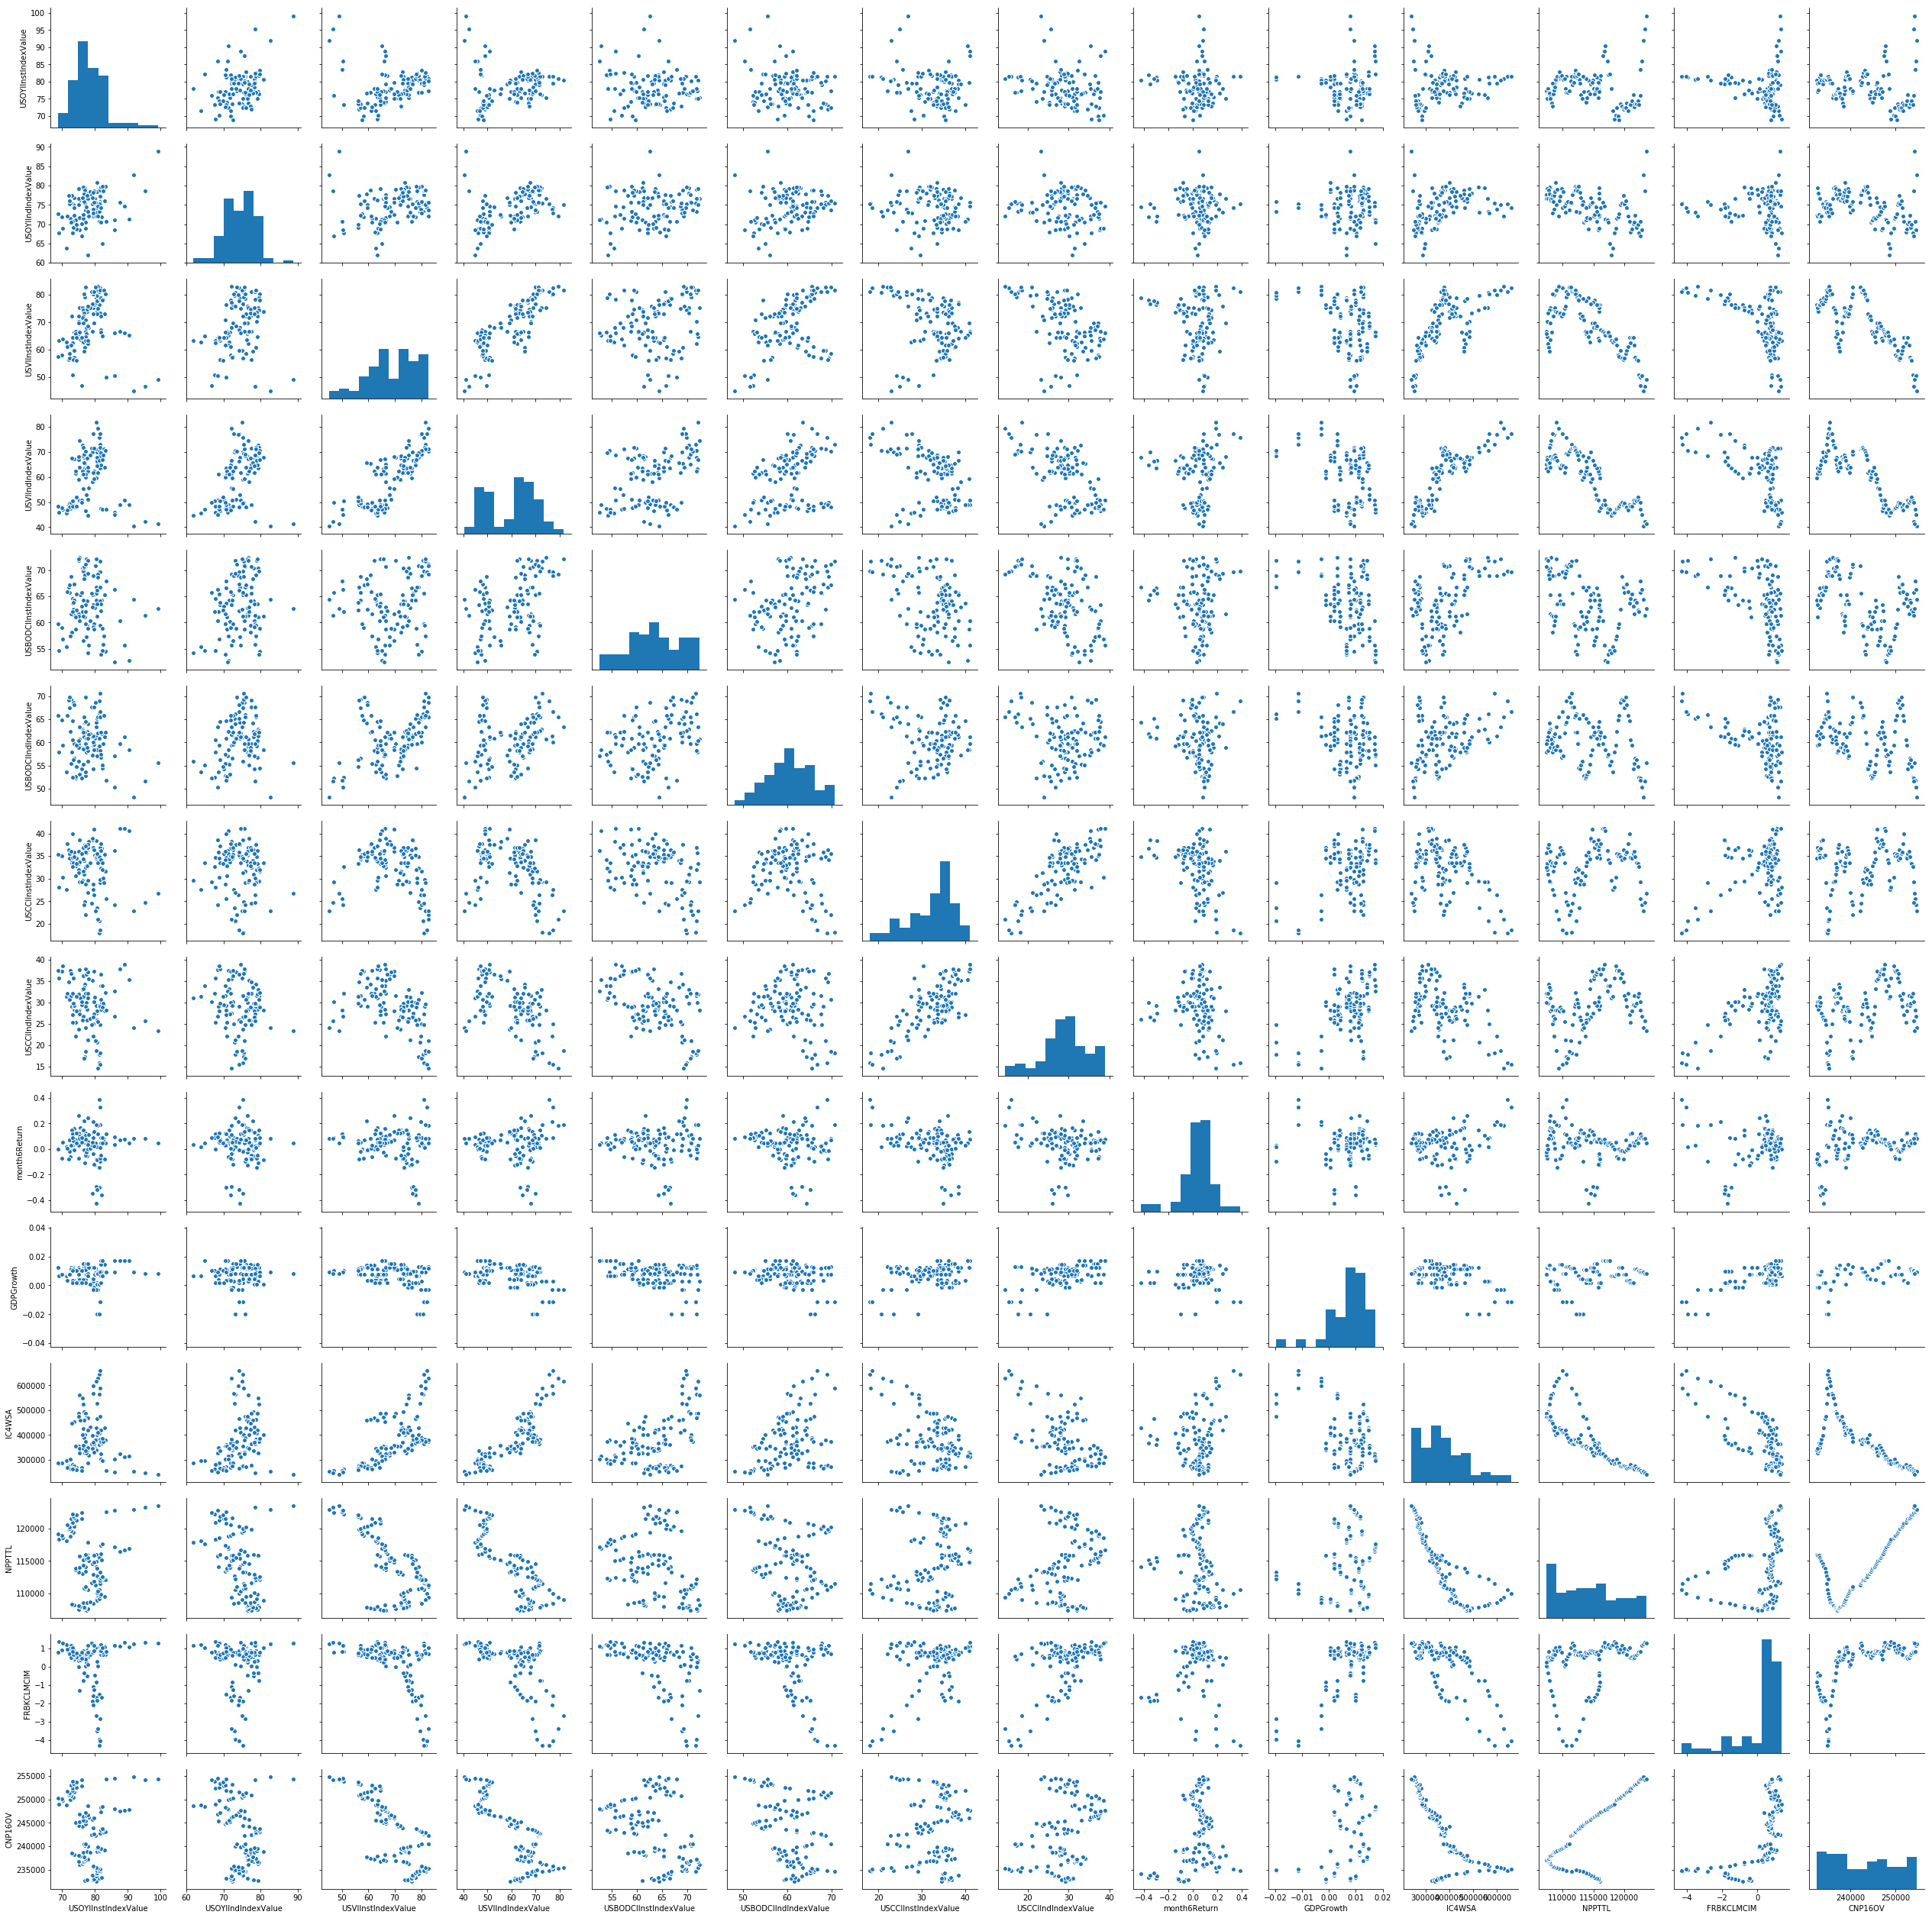

In [79]:
sns.pairplot(total)

In [80]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV

C:\Users\aj282\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\aj282\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [81]:
# total.rename(index=str, columns={'6month Return': 'month6Return'}, inplace=True)

In [82]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('month6Return ~ USOYIInstIndexValue + USVIInstIndexValue + USBODCIInstIndexValue + USCCIInstIndexValue + USOYIIndIndexValue + USVIIndIndexValue + USBODCIIndIndexValue + USCCIIndIndexValue + IC4WSA + NPPTTL + FRBKCLMCIM + CNP16OV + GDPGrowth', data=total, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

C:\Users\aj282\Anaconda3\lib\site-packages\patsy\util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           month6Return   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     9.435
Date:                Fri, 06 Oct 2017   Prob (F-statistic):           2.05e-12
Time:                        11:04:54   Log-Likelihood:                 118.91
No. Observations:                 113   AIC:                            -209.8
Df Residuals:                      99   BIC:                            -171.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.2007      1.274     -1.728      0.087      -4.728       0.327
USOYIInstIndexValue      -0.0012      0.002     -0.506      0.614      -0.006       0.004
USVIInstIndexValue       -0.0023      0.003     -0.872      0.385      -0.008       0.003
USBODCIInstIndexValue    -0.0055      0.003     -1.972      0.051      -0.011     3.3e-05
USCCIInstIndexValue      -0.0049      0.003     -1.734      0.086      -0.010       0.001
USOYIIndIndexValue       -0.0015      0.003     -0.454      0.651      -0.008       0.005
USVIIndIndexValue        -0.0007      0.003     -0.246      0.806      -0.007       0.005
USBODCIIndIndexValue      0.0003      0.003      0.121      0.904      -0.005       0.006
USCCIIndIndexValue       -0.0038      0.003     -1.207      0.230      -0.010       0.002
IC4WSA                 9.917e-07   5.57e-07      1.782      0.078   -1.13e-07     2.1e-06
NPPTTL                -1.082e-05   1.14e-05     -0.946      0.347   -3.35e-05    1.19e-05
FRBKCLMCIM                0.0074      0.034      0.220      0.827      -0.060       0.075
CNP16OV                1.689e-05   4.51e-06      3.747      0.000    7.95e-06    2.58e-05
GDPGrowth                -0.0976      1.910     -0.051      0.959      -3.887       3.692
==============================================================================
Omnibus:                        6.674   Durbin-Watson:                   0.567
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                7.604
Skew:                          -0.354   Prob(JB):                       0.0223
Kurtosis:                       4.055   Cond. No.                     1.06e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
X=total.loc[:,["USOYIInstIndexValue", "USVIInstIndexValue", "USBODCIInstIndexValue", "USCCIInstIndexValue", "USOYIIndIndexValue", "USVIIndIndexValue", "USBODCIIndIndexValue", "USCCIIndIndexValue", "IC4WSA", 'NPPTTL', "FRBKCLMCIM", "CNP16OV", "GDPGrowth"]]

y=total['month6Return']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [85]:
X_train.to_csv('C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/projects/02-luther/X_train.csv')

In [86]:
X_test.to_csv('C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/projects/02-luther/X_test.csv')
y_train.to_csv('C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/projects/02-luther/y_train.csv')
y_test.to_csv('C:/Users/aj282/OneDrive/thisismetis/sf17_ds8_workingdirectory/projects/02-luther/y_test.csv')

In [87]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [88]:
l = list(zip(X_train.columns,lr_model.coef_))
# l.to_clipboard()
l

[('USOYIInstIndexValue', -0.0012668913045496364),
 ('USVIInstIndexValue', -0.0020043516037075841),
 ('USBODCIInstIndexValue', -0.0062321873577199779),
 ('USCCIInstIndexValue', -0.002594139687777176),
 ('USOYIIndIndexValue', -0.00089674378920226927),
 ('USVIIndIndexValue', -0.0012590904573221971),
 ('USBODCIIndIndexValue', 0.0016287219379945469),
 ('USCCIIndIndexValue', -0.0063725976762173554),
 ('IC4WSA', 1.7476821350488267e-06),
 ('NPPTTL', 2.4535733049004319e-06),
 ('FRBKCLMCIM', 0.039874725272734279),
 ('CNP16OV', 1.3488629536506126e-05),
 ('GDPGrowth', -0.089326910647036031)]

In [89]:
test_set_pred = lr_model.predict(X_test)

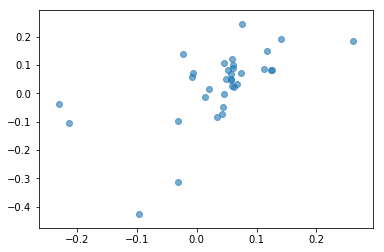

In [90]:
plt.scatter(test_set_pred,y_test,alpha=.6)
plt.plot(np.linspace(0,100,1),np.linspace(0,100,1))

In [91]:
np.sqrt(np.mean((test_set_pred - y_test)**2))

0.10481546455179735

In [92]:
(np.mean(np.abs(test_set_pred - y_test)))

0.07317643327140955

In [93]:
from sklearn.metrics import r2_score
r2_score(y_test, test_set_pred)

0.33492672680122204

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path

In [95]:
std = StandardScaler()
#std.fit(X_train.values.astype(float))
std.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [96]:
X_tr = std.transform(X_train)
X_te = std.transform(X_test)

In [97]:
alphavec = 10**np.linspace(-3,9,27)

In [98]:
lr_model = LassoCV(alphas = alphavec)
lr_model.fit(X_tr,y_train)

LassoCV(alphas=array([  1.00000e-03,   2.89427e-03,   8.37678e-03,   2.42446e-02,
         7.01704e-02,   2.03092e-01,   5.87802e-01,   1.70125e+00,
         4.92388e+00,   1.42510e+01,   4.12463e+01,   1.19378e+02,
         3.45511e+02,   1.00000e+03,   2.89427e+03,   8.37678e+03,
         2.42446e+04,   7.01704e+04,   2.03092e+05,   5.87802e+05,
         1.70125e+06,   4.92388e+06,   1.42510e+07,   4.12463e+07,
         1.19378e+08,   3.45511e+08,   1.00000e+09]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [99]:
list(zip(X_train.columns,lr_model.coef_))

[('USOYIInstIndexValue', -0.0034332937069261344),
 ('USVIInstIndexValue', -0.0092208332700989149),
 ('USBODCIInstIndexValue', -0.017925544694377998),
 ('USCCIInstIndexValue', -0.021108576277239499),
 ('USOYIIndIndexValue', -0.0),
 ('USVIIndIndexValue', -0.0),
 ('USBODCIIndIndexValue', -0.0),
 ('USCCIIndIndexValue', -0.014062662537505906),
 ('IC4WSA', 0.11636437046165032),
 ('NPPTTL', -0.012874923405310603),
 ('FRBKCLMCIM', 0.018881705197483105),
 ('CNP16OV', 0.09876563762031676),
 ('GDPGrowth', 0.0)]

In [100]:
lr_model.alpha_

0.0028942661247167516

In [101]:
test_set_pred = lr_model.predict(X_te)

In [102]:
np.sqrt(np.mean((test_set_pred - y_test)**2))

0.10245737165875946

In [103]:
from sklearn.metrics import r2_score
r2_score(y_test, test_set_pred)

0.36451516677789397

In [104]:
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso', verbose=True)

.

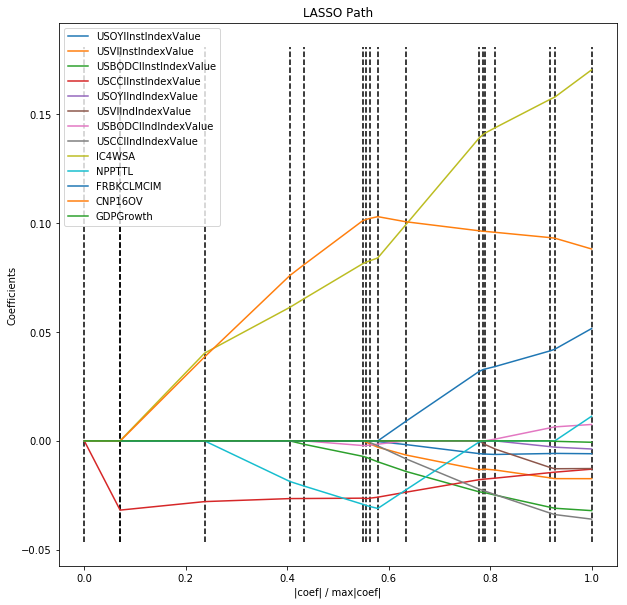

In [105]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [106]:
from sklearn.ensemble import RandomForestRegressor

rfmodel=RandomForestRegressor(n_estimators = 500, min_samples_leaf=1,  n_jobs=-1, max_features=4) #Your parameters inside the parentheses
rfmodel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [107]:
rf_test_pred = rfmodel.predict(X_test)

[]

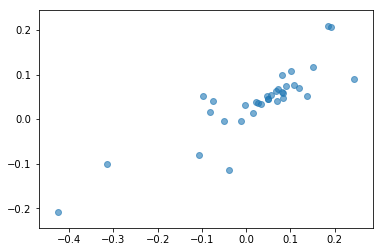

In [108]:
#Plot actual vs predicted
plt.scatter(y_test, rf_test_pred,alpha=.6)
plt.plot() #np.linspace(0,600000,1000),np.linspace(0,600000,1000))

In [109]:
dtr = rfmodel.estimators_


In [110]:
dtr1 = dtr[0]


In [124]:
dtr1.tree_


tree.export_graphviz(dtr1, out_file='rftree1.dot',feature_names = X_train.columns)

In [125]:
rfmodel.score(X_test,y_test)

0.66396990950199442

In [126]:
np.sqrt(np.mean((rf_test_pred - y_test)**2))

0.074504018914953868

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

gbmodel1 = GradientBoostingRegressor(n_estimators=500, learning_rate=.05, max_depth=4, subsample = .9)

gbmodel1.fit(X_train, y_train)

y_pred_gbl = gbmodel1.predict(X_test)



In [128]:
gbmodel1.score(X_test,y_test)

0.64266338221802211

In [129]:
np.sqrt(np.mean((y_pred_gbl - y_test)**2))

0.076829742385744706

In [130]:
from sklearn import tree

# Set some parameters
dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=4)
#dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=6, min_samples_leaf=8)

# Fit the model to some training data
dtrmodel.fit(X_train,y_train)


dtrmodel.tree_

tree.export_graphviz(dtrmodel, out_file='tree.dot',feature_names = X_train.columns)

# !head tree.dot

In [131]:
dtrmodel.score(X_test,y_test)

0.20283592534994022

[]

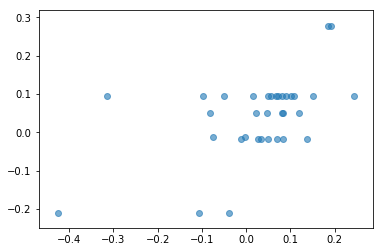

In [132]:
dtr_test_pred = dtrmodel.predict(X_test)
#Plot actual vs predicted
plt.scatter(y_test, dtr_test_pred,alpha=.6)
plt.plot() #np.linspace(0,600000,1000),np.linspace(0,600000,1000))

In [133]:
np.sqrt(np.mean((dtr_test_pred - y_test)**2))

0.11475311276319368

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,ensemble, tree, model_selection

parameters = {'max_depth':[5,6],
              'learning_rate':np.arange(.01,.1,.01),
              'n_estimators':[500]}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition

steps = [
('features', preprocessing.PolynomialFeatures(degree=2)),
('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha = .2))),
('model',ensemble.GradientBoostingRegressor())]

gbr_regression_pipeline = pipeline.Pipeline(steps)
gbr_regression_pipeline.fit(X_train,y_train)
gbr_regression_pipeline.score(X_test,y_test)




Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-2)]: Done  54 out of  54 | elapsed:    8.2s finished
C:\Users\aj282\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.78787939513147331

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,ensemble, tree, model_selection

parameters = {'max_depth':[5,6],
              'learning_rate':np.arange(.01,.1,.01),
              'n_estimators':[500]}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition

steps = [
('features', preprocessing.PolynomialFeatures(degree=2)),
('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha = .2))),
('model',ensemble.GradientBoostingRegressor())]

gbr_regression_pipeline = pipeline.Pipeline(steps)
gbr_regression_pipeline.fit(X_train,y_train)
gbr_regression_pipeline.score(X_test,y_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-2)]: Done  54 out of  54 | elapsed:   11.2s finished
C:\Users\aj282\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.75726342228332333

In [145]:
gbr_test_pred = gbr_regression_pipeline.predict(X_test)

In [146]:
np.sqrt(np.mean((gbr_test_pred - y_test)**2))

0.06332252557446344

In [135]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,ensemble, tree, model_selection

parameters = {'max_depth':[5,6],
              'n_estimators':[500]}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition

steps = [
('features', preprocessing.PolynomialFeatures(degree=2)),
('model',ensemble.RandomForestRegressor())]

regression_pipeline = pipeline.Pipeline(steps)
regression_pipeline.fit(X_train,y_train)
regression_pipeline.score(X_test,y_test)




Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:    6.2s finished


0.51263313620704554

In [136]:
rfr_test_pred = regression_pipeline.predict(X_test)

np.sqrt(np.mean((rfr_test_pred - y_test)**2))

0.089726063532362926

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,ensemble, tree, model_selection

parameters = {'max_depth':[4,5,6],
              'n_estimators':[100, 250, 500]}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition

steps = [
# ('features', preprocessing.PolynomialFeatures(degree=2)),
('model',ensemble.RandomForestRegressor())]

regression_pipeline = pipeline.Pipeline(steps)
regression_pipeline.fit(X_train,y_train)
regression_pipeline.score(X_test,y_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-2)]: Done  27 out of  27 | elapsed:    6.7s finished


0.50202524184189978

In [138]:
rfr_test_pred = regression_pipeline.predict(X_test)

np.sqrt(np.mean((rfr_test_pred - y_test)**2))

0.090697283678019602

In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model,ensemble, tree, model_selection

parameters = {'max_depth':[4,5,6],
              'learning_rate':np.arange(.01,.1,.01),
              'n_estimators':[100, 250, 500]}

model = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
grid_search.fit(X_train,y_train)

from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition

steps = [
# ('features', preprocessing.PolynomialFeatures(degree=2)),
# ('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha = .2))),
('model',ensemble.GradientBoostingRegressor())]

regression_pipeline = pipeline.Pipeline(steps)
regression_pipeline.fit(X_train,y_train)
regression_pipeline.score(X_test,y_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-2)]: Done 238 out of 243 | elapsed:   12.4s remaining:    0.2s
[Parallel(n_jobs=-2)]: Done 243 out of 243 | elapsed:   12.5s finished


0.6391086953764058

In [140]:
gbr_test_pred = regression_pipeline.predict(X_test)

np.sqrt(np.mean((gbr_test_pred - y_test)**2))

0.077210937347291578

## Gradient Boosting with early stop

In [141]:
## Makes a monitor where the mean of last x oob improvements
## are used to determine early stopping. This can be ammended
## to any stopping criteria one sees as fit - consecutive x 
## negatives, more negatives than positives in last x, etc.

def make_monitor(running_mean_len):
    def monitor(i,self,args):
        if np.mean(self.oob_improvement_[max(0,i-running_mean_len+1):i+1])<0:
            return True
        else:
            return False
    return monitor

In [142]:
from sklearn.ensemble import GradientBoostingRegressor

gbmodel1 = GradientBoostingRegressor(n_estimators=500, learning_rate=.05, max_depth=4, subsample = .9)
monitor = make_monitor(25)

gbmodel1.fit(X_train, y_train, monitor=monitor)

y_pred_gbl = gbmodel1.predict(X_test)
gbmodel1.score(X_test,y_test)

0.58162701615759005

In [143]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model,ensemble, tree, model_selection

# parameters = {'max_depth':[4,5,6],
#               'learning_rate':np.arange(.01,.1,.01),
#               'n_estimators':[100, 250, 500],
#               'monitor': make_monitor(10)
#               }

# model = ensemble.GradientBoostingRegressor()
# grid_search = GridSearchCV(model, parameters, n_jobs=-2, verbose=1)
# # monitor = make_monitor(10)
# grid_search.fit(X_train,y_train, monitor=monitor)

# # from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition

# # steps = [
# # # ('features', preprocessing.PolynomialFeatures(degree=2)),
# # # ('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha = .2))),
# # ('model',ensemble.GradientBoostingRegressor())]

# # monitor = make_monitor(n_estimators/10)
# # regression_pipeline = pipeline.Pipeline(steps)
# # regression_pipeline.fit(X_train,y_train,monitor=monitor)
# # regression_pipeline.score(X_test,y_test)

## LightGBM

In [2]:
# import lightgbm as lgb